# SciCar 2023

This notebook aims at explaining how Sentinel-2 satellite data can be retrieved from the Sentinelhub. The data excerpt is adjusted to cover user-defined spatial regions and time ranges, so one ends up with images of the same region for different, evenly spaced time steps. Ultimately, the data is plotted.
It requires that (a) users install the [xcube-sh plugin](https://github.com/dcs4cop/xcube-sh) and that they have Sentinelhub credentials. You can get credentials as well as a free trial account here: https://www.sentinel-hub.com/ .

This notebook uses [xcube](https://github.com/dcs4cop/xcube). xcube is an open-source Python package designed to open and work with data cubes. There exist several plugins to establish connections to different data sources, e.g., the Sentinelhub. In the context of the SciCAR notebooks, we are focussing on opening and displaying data.

We start with necessary imports. The upper three imports are used for display data more nicely. The xcube imports at the bottom are used to establish the actual data access.

In [1]:
import IPython
from IPython.display import JSON

import shapely

from xcube.core.store import find_data_store_extensions
from xcube.core.store import new_data_store

We start with seeing to that the software is set up correctly by looking for the SentinelHub plugin. There should be an entry 'sentinelhub' popping up in the list below. If it doesn't the software is not set up correctly.

In [2]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

## Opening Sentinel-2 Data

Now we can move on to open data. xcube uses the concept of data stores. With the 'new_data_store' command we establish an access to the Sentinelhub.

In [3]:
sh_store = new_data_store('sentinelhub')
sh_store

Before we download any data, we determine a spatial region we are interested in. In this notebook, we focus on Hamburg.

In [4]:
spatial_envelope = [9.7, 53.4, 10.2, 53.7]
IPython.display.GeoJSON(shapely.geometry.box(*spatial_envelope).__geo_interface__)

<IPython.display.GeoJSON object>

In [5]:
sh_store.list_data_ids()

['S2L1C', 'S1GRD', 'S2L2A', 'DEM']

Now we can open an actual dataset. We want Sentinel-2 data, so we request 'S2L2A'. With the parameter 'variable_names' you can restrict which bands to retrieve. 'spatial_res' defines the spatial resolution. The value '0.0018' roughly corresponds to 20m in WGS84 coordinates. Finally, with parameters 'time_range' and 'time_period' you may choose the a time region and the desired temporal difference between images.

In [6]:
dataset = sh_store.open_data(
    'S2L2A', 
    variable_names=['B04'], 
    bbox=spatial_envelope,
    spatial_res=0.0018, 
    time_range=('2020-08-10','2020-08-20'), 
    time_period='2D'
)
dataset

<xarray.Dataset>
Dimensions:    (time: 6, lat: 167, lon: 278, bnds: 2)
Coordinates:
  * lat        (lat) float64 53.7 53.7 53.7 53.69 53.69 ... 53.41 53.4 53.4 53.4
  * lon        (lon) float64 9.701 9.703 9.704 9.706 ... 10.19 10.2 10.2 10.2
  * time       (time) datetime64[ns] 2020-08-11 2020-08-13 ... 2020-08-21
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(6, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 278), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2023-10-05T17:11:12.904852
    time_coverage_start:       2020-08-10T00:00:00+00:00
    time_coverage_end:         2020-08-22T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P2DT0H0M0S
    geospatial_lon_min:        9.7
    geospatial_lat_min:        53.4
    geospatial_lon_max:        10.200399999999998
    geospatial_lat_max:        53.7006
    processing_level:          L2A

The dataset is opened immediately. You will see that under 'Data Variables' it lists the variables we asked for and that the coordinates ('lat', 'lon', and 'time') correspond to the parameters we entered above. Data is first actually loaded into memory when you plot it or work with it otherwise.

We now can plot the data. The code below will plot all the data to an interval between 0 and 0.2, using a monochromatic color map.

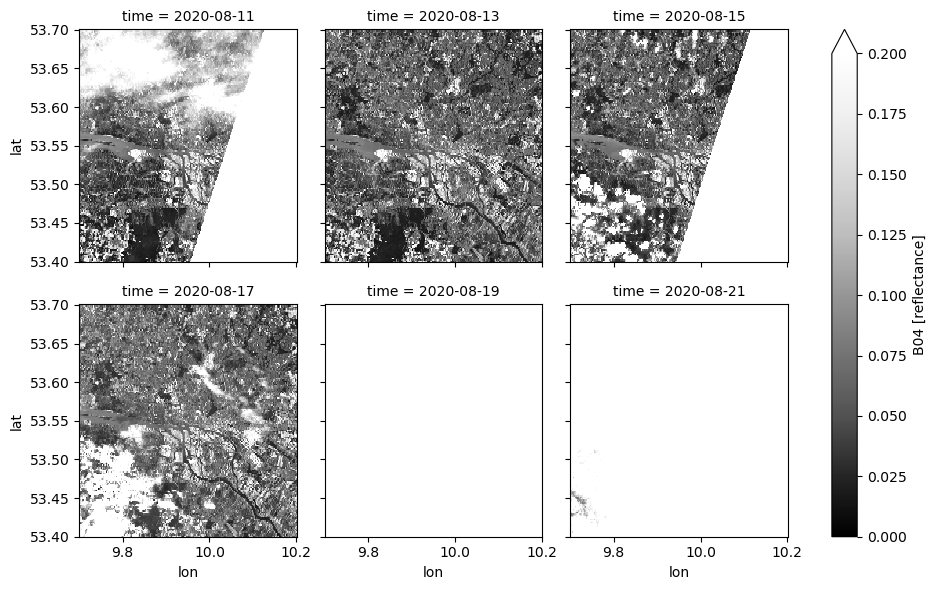

In [7]:
dataset.B04.plot.imshow(col="time", col_wrap=3, vmin=0, vmax=0.2, cmap='Greys_r')

Some images above are empty, because no S2 observations were available for the requested time steps. One may therefore attempt to make the time period coarser, so we increase the chance there are measurements available. Also, we set the parameter 'mosaicking_order' to 'leastCC', which means that, in case there are multiple images available, we want the image with least cloud coverage (default is to take the most recent one).

In [8]:
s2_dataset_2 = sh_store.open_data(
    'S2L2A', 
    variable_names=['B04'], 
    bbox=spatial_envelope,
    spatial_res=0.0018, 
    time_range=('2020-08-10','2020-08-20'), 
    time_period='5D',
    mosaicking_order='leastCC'
)
s2_dataset_2

<xarray.Dataset>
Dimensions:    (time: 3, lat: 167, lon: 278, bnds: 2)
Coordinates:
  * lat        (lat) float64 53.7 53.7 53.7 53.69 53.69 ... 53.41 53.4 53.4 53.4
  * lon        (lon) float64 9.701 9.703 9.704 9.706 ... 10.19 10.2 10.2 10.2
  * time       (time) datetime64[ns] 2020-08-12T12:00:00 ... 2020-08-22T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 278), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2023-10-05T17:11:17.826227
    time_coverage_start:       2020-08-10T00:00:00+00:00
    time_coverage_end:         2020-08-25T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    geospatial_lon_min:        9.7
    geospatial_lat_min:        53.4
    geospatial_lon_max:        10.200399999999998
    geospatial_lat_max:        53.7006
    processing_level:          L2A

We may now plot the data once more. You will see that now we get a full spatial coverage (though still not fully cloud free).

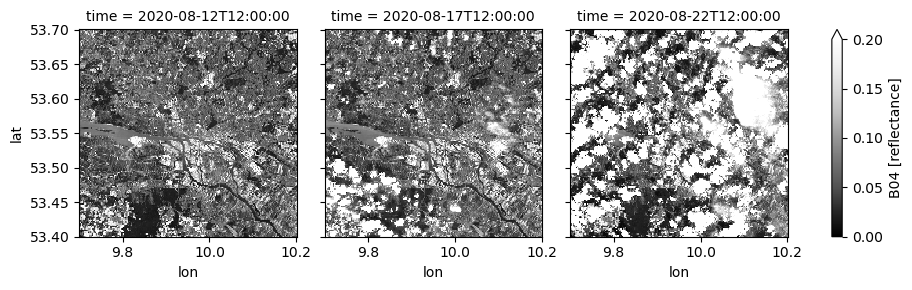

In [9]:
s2_dataset_2.B04.plot.imshow(col="time", col_wrap=3, vmin=0, vmax=0.2, cmap='Greys_r')

Finally, if you request more bands you can also create RGB images. We are moving the spatial region to Africa for this purpose.

In [10]:
s2_dataset_3 = sh_store.open_data(
    'S2L2A', 
    variable_names=['B02', 'B03', 'B04'], 
    bbox=[9.7, 23.4, 10.2, 23.7],
    spatial_res=0.0018, 
    time_range=('2020-08-10','2020-08-24'), 
    time_period='5D',
    mosaicking_order='leastCC'
)
s2_dataset_3

<xarray.Dataset>
Dimensions:    (time: 3, lat: 167, lon: 278, bnds: 2)
Coordinates:
  * lat        (lat) float64 23.7 23.7 23.7 23.69 23.69 ... 23.41 23.4 23.4 23.4
  * lon        (lon) float64 9.701 9.703 9.704 9.706 ... 10.19 10.2 10.2 10.2
  * time       (time) datetime64[ns] 2020-08-12T12:00:00 ... 2020-08-22T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 278), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 278), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 278), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2023-10-05T17:11:20.031321
    time_coverage_start:       2020-08-10T00:00:00+00:00
    time_coverage_end:         2020-08-25T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    geospatial_lon_min:        9.7
    geospatial_lat_min:        23.4
    geospatial_lon_max:        10.200399999999998
    geospatial_lat_max:        23.700599999999998
    processing_level:          L2A

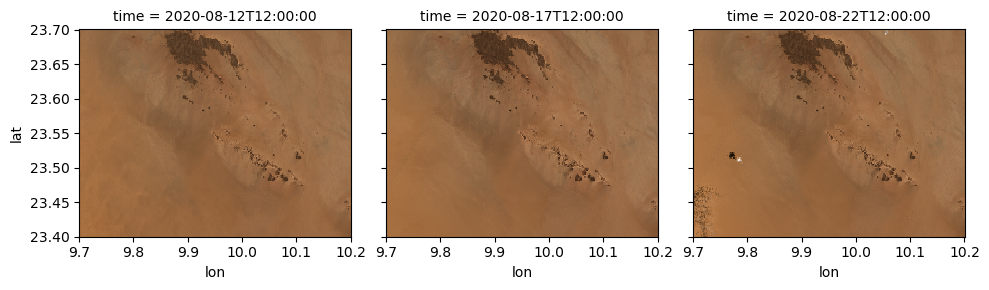

In [11]:
s2_dataset_3[["B04", "B03", "B02"]].to_array("var").plot.imshow(rgb="var", col="time", col_wrap=3)